# Notebook for Disinformation classification with BERT

# Load the dataset

In [1]:
!pip install transformers
!pip install datasets

In [2]:
import pandas as pd

In [3]:
df_true = pd.read_csv('/kaggle/input/synthetic-data/synthetic_data.csv', usecols=['summary'])
df_fake = pd.read_csv('/kaggle/input/synthetic-data/synthetic_data.csv', usecols=['fake_news'])

In [4]:
df_fake['label'] = 0
df_true['label'] = 1
df_fake.head()

,fake_news,label
0,"In a surprise move, the government has announc...",0
1,"In a crackdown on homegrown extremism, Singapo...",0
2,"In a shocking turn of events, a 19-year-old un...",0
3,The highly anticipated Paws & Relax Festival i...,0
4,"In a shocking turn of events, Emily Tan, a hig...",0


In [5]:
df_fake = df_fake.rename(columns={'fake_news': 'text'})
df_real = df_true.rename(columns={'summary': 'text'})
df = pd.concat([df_fake, df_real], ignore_index=True)
df = df.sample(frac=1).reset_index(drop=True)
df.head()


,text,label
0,Law and Home Affairs Minister K Shanmugam crit...,1
1,Posting results for the 2025 Joint Admissions ...,1
2,Singapore is experiencing La Nina-like conditi...,1
3,A disturbing incident unfolded in suburban Spr...,0
4,Tim Phillips from TimTalksMoney discusses the ...,1


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 796 entries, 0 to 795
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    796 non-null    object
 1   label   796 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 12.6+ KB


In [7]:
import datasets

In [8]:
dataset = datasets.Dataset.from_pandas(df)
dataset

Dataset({
    features: ['text', 'label'],
    num_rows: 796
})

## Split training set into train-val (80/20)

In [9]:
from sklearn.model_selection import train_test_split

train, validation = train_test_split(list(dataset), test_size=0.2, random_state=42)

In [10]:
len(train), len(validation)

(636, 160)

In [11]:
train[0]

{'text': "A 41-year-old father of two was taken into custody yesterday for allegedly posting sensitive details about his 12-year-old daughter on social media, in direct contravention of the Children's Online Protection Act. The man, who cannot be named to protect the identity of the minor, is expected to face a total of five charges in court next month, with each charge carrying a maximum penalty of S$10,000 or imprisonment for up to a year. If convicted, he may also be required to attend a mandatory parenting program to educate him on responsible online behavior and child protection laws. The case is set to be heard on March 15, and the community is eagerly awaiting the outcome, sparking a broader discussion about digital safety and parental responsibility in the age of social media.",
 'label': 0}

In [12]:
validation[20]

{'text': 'Darren Lim and Evelyn Tan, a couple featured on Mediacorp\'s "Camping Around the World," faced significant disapproval from Tan\'s family when they began dating. Despite the challenges, including a six-year courtship and initial judgments based on Lim\'s past roles, they married in 2004 and have four children. Over time, Tan\'s parents came to accept Lim, recognizing his sincerity and commitment.',
 'label': 1}

# Using and exploring the Tokenizer from `transformers`

In [13]:
from transformers import BertTokenizer
from torch.utils.data import TensorDataset

In [14]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [15]:
MAX_LEN = 512

# Create Custom Dataset Class

In [16]:
from torch.utils.data import Dataset, DataLoader
import torch

class CustomDataset(Dataset):

    def __init__(self, data, tokenizer, max_len):
        self.data = data
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.features = [d['text'] for d in self.data]
        self.labels = [d['label'] for d in self.data]

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        feature = str(self.features[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            feature,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'review_text': feature,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(label, dtype=torch.float)
        }

In [17]:
import numpy as np

train_dataset = CustomDataset(train, tokenizer, MAX_LEN)
val_dataset = CustomDataset(validation, tokenizer, MAX_LEN)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)

In [18]:
iter_sample = iter(train_loader)
sample = next(iter_sample)
sample.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

# Building the Model

In [19]:
from torch import nn
from transformers import BertModel

class CustomModel(nn.Module):

    def __init__(self, numcl=1):
        super().__init__()
        self.model = BertModel.from_pretrained("bert-base-uncased", torch_dtype=torch.float, attn_implementation="sdpa", return_dict=False)
        self.drop = nn.Dropout(p=0.3)
        self.fc = nn.Linear(self.model.config.hidden_size, numcl)

    def forward(self, input_ids, attn_mask):
        _, pooled_output = self.model(
            input_ids=input_ids,
            attention_mask=attn_mask)
        output = self.drop(pooled_output)
        return self.fc(output)


# Hyperparameters

In [20]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
NUM_EPOCHS = 10

model = CustomModel()
model = nn.DataParallel(model)
model.to(device)


optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)
criterion = nn.BCEWithLogitsLoss()

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

# Creating the Main Functions

### Training function

In [21]:
def train_epoch(train_loader, model, criterion, optimizer, device):
    model.train()

    losses = []

    for batch_idx, data in enumerate(train_loader):
        inputs, attention_mask, labels = data['input_ids'].to(device), data['attention_mask'].to(device), data['targets'].to(device)

        optimizer.zero_grad()
        preds = model(inputs, attention_mask)
        labels = labels.unsqueeze(1)
        loss = criterion(preds, labels)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
    return losses

### Validation function

In [22]:
def evaluate(data_loader, model, criterion, device):
    model.eval()

    with torch.no_grad():
        total_correct = 0
        total_samples = 0
        total_loss = 0

        for data in data_loader:
            features, attention_mask, labels = data['input_ids'].to(device), data['attention_mask'].to(device), data['targets'].to(device)

            outputs = model(features, attention_mask)
            labels = labels.unsqueeze(1)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            # output is raw logits
            outputs_sigmoid = torch.sigmoid(outputs)
            preds = (outputs_sigmoid >= 0.5).float()
            
            total_correct += (preds.squeeze() == labels.squeeze()).sum().item()
            total_samples += labels.size(0)

        avg_loss = total_loss / len(data_loader)
        accuracy = total_correct / total_samples * 100
    return avg_loss, accuracy


In [23]:
def train_modelcv(train_loader, test_loader, model, criterion, optimizer, num_epochs, device, scheduler=None):
    train_losses = []
    val_losses = []
    best_measure = 0
    best_epoch = -1

    for epoch in range(num_epochs):
        print(f"Epoch {epoch}/{num_epochs-1}")
        print("-" * 10)

        train_loss = train_epoch(train_loader, model, criterion, optimizer, device)
        train_losses.append(train_loss)

        val_loss, measure = evaluate(test_loader, model, criterion, device)
        val_losses.append(val_loss)

        # scheduler.step(measure)

        print("Performance measure: ", measure)
        print("Current Learning Rate: ", optimizer.param_groups[0]['lr'])

        if measure > best_measure:
            best_weights = model.state_dict()
            best_measure = measure
            best_epoch = epoch
            print(f"Current Best is epoch {best_epoch} with {best_measure} %")

    return best_weights, best_measure, best_epoch, train_losses, val_losses

In [24]:
best_weights, best_measure, best_epoch, train_losses, val_losses = train_modelcv(train_loader,
                                                                                 val_loader,
                                                                                 model,
                                                                                 criterion,
                                                                                 optimizer,
                                                                                 NUM_EPOCHS,
                                                                                 device)

Epoch 0/9
----------
Performance measure:  91.25
Current Learning Rate:  2e-05
Current Best is epoch 0 with 91.25 %
Epoch 1/9
----------
Performance measure:  97.5
Current Learning Rate:  2e-05
Current Best is epoch 1 with 97.5 %
Epoch 2/9
----------
Performance measure:  97.5
Current Learning Rate:  2e-05
Epoch 3/9
----------
Performance measure:  96.875
Current Learning Rate:  2e-05
Epoch 4/9
----------
Performance measure:  96.875
Current Learning Rate:  2e-05
Epoch 5/9
----------
Performance measure:  99.375
Current Learning Rate:  2e-05
Current Best is epoch 5 with 99.375 %
Epoch 6/9
----------
Performance measure:  99.375
Current Learning Rate:  2e-05
Epoch 7/9
----------
Performance measure:  99.375
Current Learning Rate:  2e-05
Epoch 8/9
----------
Performance measure:  99.375
Current Learning Rate:  2e-05
Epoch 9/9
----------
Performance measure:  99.375
Current Learning Rate:  2e-05


In [25]:
torch.save(best_weights, "best_bert_weights.pt")

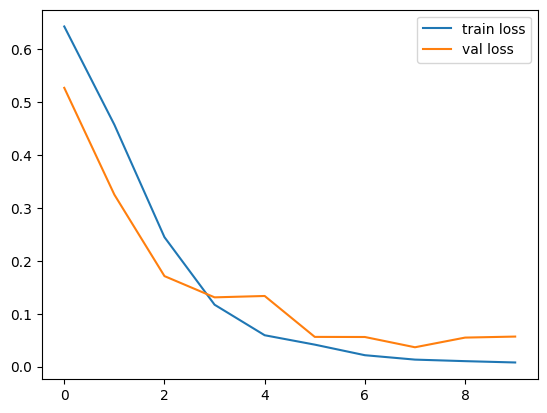

In [26]:
import matplotlib.pyplot as plt

train_losses = [np.mean(i) for i in train_losses]

plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='val loss')
plt.legend()
plt.show()

# Run on test set

In [27]:
df_true = pd.read_csv('/kaggle/input/test-data/test_data.csv', usecols=['summary'])
df_fake = pd.read_csv('/kaggle/input/test-data/test_data.csv', usecols=['fake_news'])

In [28]:
df_fake['label'] = 0
df_true['label'] = 1
df_fake.head()

,fake_news,label
0,Singapore experienced its coolest winter on re...,0
1,"K-pop sensation, Jimin, is set to embark on a ...",0
2,KFC in Malaysia is launching a limited-edition...,0
3,Vice President Kamala Harris has postponed her...,0
4,"A new initiative, ""Conversations Beyond,"" has ...",0


In [29]:
df_fake = df_fake.rename(columns={'fake_news': 'text'})
df_real = df_true.rename(columns={'summary': 'text'})
df = pd.concat([df_fake, df_real], ignore_index=True)
df = df.sample(frac=1).reset_index(drop=True)
df.head()


,text,label
0,Singaporean TikToker Luke Chan and gym partner...,1
1,Singapore's Health Ministry reports a seasonal...,1
2,"Amanda Tan, 29, was sentenced to 18 months in ...",0
3,A string of violent knife attacks has shaken t...,0
4,"In a recent crackdown on property crimes, Sing...",0


In [30]:
dataset_test = datasets.Dataset.from_pandas(df)
dataset_test

Dataset({
    features: ['text', 'label'],
    num_rows: 398
})

In [31]:
test_dataset = CustomDataset(dataset_test, tokenizer, MAX_LEN)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

In [44]:
model.load_state_dict(torch.load("best_bert_weights.pt"))

model.eval()
correct_prediction = {}
wrong_prediction = {}
true_labels = []
pred_labels = []


with torch.no_grad():
    total_correct = 0
    total_samples = 0
    total_loss = 0
    for idx, data in enumerate(test_loader):
        if idx % 20 == 0:
            print(f"Processing Batch {idx}")
        features, attention_mask, labels = data['input_ids'].to(device), data['attention_mask'].to(device), data['targets'].to(device)

        logits = model(features, attention_mask)
        labels = labels.unsqueeze(1)
        loss = criterion(logits, labels)
        total_loss += loss.item()

        outputs = torch.sigmoid(logits)
        preds = (outputs >= 0.5).float()

        # run this only when dictionaries are empty
        if not correct_prediction and not wrong_prediction:
            for i in range(features.size(0)):
                original_text = data['review_text'][i]
                token_ids = list(map(lambda x: x.item(), data['input_ids'][i]))
                tokens = tokenizer.convert_ids_to_tokens(token_ids)
                raw_logits = logits[i].tolist()
    
                entry = {
                    "original_text": original_text,
                    "tokens_and_id": (tokens, token_ids),
                    "raw_logits": raw_logits,
                    "sigmoid_prob": outputs[i],
                    "true_label": labels[i],
                    "pred_label": preds[i]
                }
    
                if preds[i] == labels[i]:
                    if not correct_prediction:  # Add only one entry.
                        correct_prediction = entry
                else:
                    if not wrong_prediction:  # Add only one entry.
                        wrong_prediction = entry
        total_correct += (preds.squeeze() == labels.squeeze()).sum().item()
        total_samples += labels.size(0)
        pred_labels.extend(preds.squeeze())
        true_labels.extend(labels.squeeze())

    avg_loss = total_loss / len(test_loader)
    accuracy = total_correct / total_samples * 100
        

<ipython-input-44-604183591c41>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_bert_weights.pt"))


Processing Batch 0


In [47]:
print(f"Avg loss: {avg_loss}")
print(f"Test accuracy: {accuracy}")

Avg loss: 0.06162772214572344
Test accuracy: 98.24120603015075


# Get info of correct prediction

In [48]:
correct_prediction['original_text']

"Singaporean TikToker Luke Chan and gym partner Jayden Loh open Pasta Papa, a 60-seater eatery in Bukit Merah. The unique concept allows customers to cook their own pasta dishes or opt for chef-prepared meals. Initial customer response is positive, with a mix of Chan's followers and local diners. The business also offers a regular menu with signature pasta and risotto dishes."

In [49]:
token_id_list = list(zip(correct_prediction['tokens_and_id'][0], correct_prediction['tokens_and_id'][1]))
len(token_id_list)

512

In [50]:
out = set(token_id_list)
print(sorted(out, key = lambda x:x[1]))

[('[PAD]', 0), ('[CLS]', 101), ('[SEP]', 102), ("'", 1005), (',', 1010), ('-', 1011), ('.', 1012), ('a', 1037), ('s', 1055), ('the', 1996), ('of', 1997), ('and', 1998), ('in', 1999), ('to', 2000), ('is', 2003), ('for', 2005), ('with', 2007), ('##s', 2015), ('or', 2030), ('also', 2036), ('their', 2037), ('##r', 2099), ('##y', 2100), ('own', 2219), ('##h', 2232), ('##an', 2319), ('open', 2330), ('local', 2334), ('business', 2449), ('regular', 3180), ('response', 3433), ('60', 3438), ('positive', 3893), ('initial', 3988), ('offers', 4107), ('concept', 4145), ('##den', 4181), ('partner', 4256), ('unique', 4310), ('##ah', 4430), ('allows', 4473), ('mix', 4666), ('prepared', 4810), ('singapore', 5264), ('luke', 5355), ('cook', 5660), ('jay', 6108), ('customers', 6304), ('##so', 6499), ('customer', 8013), ('signature', 8085), ('followers', 8771), ('lo', 8840), ('chan', 9212), ('##tto', 9284), ('gym', 9726), ('chef', 10026), ('dishes', 10447), ('##oke', 11045), ('menu', 12183), ('meals', 12278

In [51]:
print(f"Logits: {correct_prediction['raw_logits']} \t \
        Probability after applying sigmoid: {correct_prediction['sigmoid_prob']} \
        \nPred label: {correct_prediction['pred_label']} \t Actual label: {correct_prediction['true_label']}")

Logits: [5.520898818969727] 	         Probability after applying sigmoid: tensor([0.9960], device='cuda:0')         
Pred label: tensor([1.], device='cuda:0') 	 Actual label: tensor([1.], device='cuda:0')


# Get info of wrong prediction

In [52]:
wrong_prediction

{}

In [39]:
wrong_prediction['original_text']

KeyError: 'original_text'

In [ ]:
token_id_list = list(zip(wrong_prediction['tokens_and_id'][0], wrong_prediction['tokens_and_id'][1]))
len(token_id_list)

In [ ]:
out = set(token_id_list)
print(sorted(out, key = lambda x:x[1]))

In [ ]:
print(f"Logits: {wrong_prediction['raw_logits']} \t \
        Probability after applying sigmoid: {wrong_prediction['sigmoid_prob']} \
        \nPred label: {wrong_prediction['pred_label']} \t Actual label: {wrong_prediction['true_label']}")

# Getting F1 Score

In [53]:
!pip install --quiet torcheval

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 3.9 MB/s eta 0:00:00a 0:00:01


In [54]:
from torcheval.metrics.functional import multiclass_f1_score

multiclass_f1_score(torch.tensor(pred_labels), torch.tensor(true_labels), num_classes=2)

tensor(0.9824)

In [55]:
from sklearn.metrics import f1_score

f1_score(list(map(lambda x: x.cpu(), true_labels)), list(map(lambda x: x.cpu(), pred_labels)))

0.9825436408977556

In [56]:
from sklearn.metrics import classification_report

cls_rep = classification_report(list(map(lambda x: x.cpu(), true_labels)), list(map(lambda x: x.cpu(), pred_labels)))
print(cls_rep)

              precision    recall  f1-score   support

         0.0       0.99      0.97      0.98       199
         1.0       0.98      0.99      0.98       199

    accuracy                           0.98       398
   macro avg       0.98      0.98      0.98       398
weighted avg       0.98      0.98      0.98       398



# Give your own sample text here

In [71]:
# replace with whatever text you wanna test out
sample_text_false = "In a surprising turn of event, PM Wong will not be delivering Budget 2025 this coming 18 February."
sample_text_true = "Palestinian Territories: Gaza militants handed three Israeli hostages over to the Red Cross on Saturday (Feb 15) in an exchange that is also set to see the release of 369 Palestinians from Israeli custody, the latest such swap under an ongoing truce deal."

In [72]:
encoding = tokenizer.encode_plus(
            sample_text_false,
            add_special_tokens=True,
            max_length=512,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [73]:
feature = encoding['input_ids']
attention_mask = encoding['attention_mask']

In [74]:
outputs = model(feature, attention_mask)

# output is raw logits
outputs_sigmoid = torch.sigmoid(outputs)
preds = (outputs_sigmoid >= 0.5).float()

In [75]:
prediction = 'true' if preds == 1 else 'false'

In [76]:
print(f"The sample text is {prediction} news")

The sample text is false news


testing on true sample news

In [78]:
encoding = tokenizer.encode_plus(
            sample_text_true,
            add_special_tokens=True,
            max_length=512,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [79]:
feature = encoding['input_ids']
attention_mask = encoding['attention_mask']
outputs = model(feature, attention_mask)

# output is raw logits
outputs_sigmoid = torch.sigmoid(outputs)
preds = (outputs_sigmoid >= 0.5).float()

In [80]:
prediction = 'true' if preds == 1 else 'false'
print(f"The sample text is {prediction} news")

The sample text is true news
